<a href="https://colab.research.google.com/github/jaarck/ai_everywhere_learnings/blob/main/wild_bb_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##  To delete all folders and their contents under the /content directory in my Google Colab
##  Use this to clear all the contents that we had downloaded earlier or if you want to use a different dataset.
import shutil
import os

# Define the directory path
content_dir = '/content'

# Remove all folders and their contents under /content
for item in os.listdir(content_dir):
    item_path = os.path.join(content_dir, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("All folders under /content have been deleted.")

# Upload your Kaggle API key. FYI - I have already uploaded mine (jarockia) to run the code
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle API credentials. Make sure this is done right as dataset access is dependent on this step.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API
!pip install kaggle


All folders under /content have been deleted.


Saving kaggle.json to kaggle.json


In [7]:
!kaggle competitions download -c playground-series-s3e14

100% 634k/634k [00:00<00:00, 727kB/s]
100% 634k/634k [00:00<00:00, 727kB/s]


In [8]:
import os
import zipfile
import shutil
from collections import defaultdict

# Define directory and zip file names
dataset_dir = '/content/WildBB_Yield_DS'
zip_file = 'playground-series-s3e14.zip'

# Remove existing content if the directory exists
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)


# Function to count total files in directories up to a specified depth
def count_files_in_directories(root_dir, max_depth=3):
    # Dictionary to hold file counts
    file_counts = defaultdict(int)

    # Walk through the directory
    for root, dirs, files in os.walk(root_dir):
        # Calculate the current depth
        depth = root.replace(root_dir, '').count(os.sep)

        # Only count if within the desired depth
        if depth <= max_depth:
            # Count files in the current directory
            file_counts[root] = len(files)

            # Only process directories up to the max depth
            if depth == max_depth:
                # Remove subdirectories from further exploration
                dirs[:] = []

    # Print total file count for each directory including subdirectories
    def count_files_in_dir(directory):
        total_files = 0
        for root, _, files in os.walk(directory):
            total_files += len(files)
        return total_files

    print("Total files in each directory:")
    for directory in file_counts.keys():
        total_files = count_files_in_dir(directory)
        print(f'{directory}: {total_files} files')

# Execute to check if extraction was successful
count_files_in_directories('/content')

Total files in each directory:
/content: 5 files
/content/WildBB_Yield_DS: 3 files


In [11]:
import pandas as pd
import tensorflow as tf
import os

# Paths to the extracted dataset
extract_path = '/content/WildBB_Yield_DS'

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth on all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Print the name of the GPU being used
        print(f"Running on GPU: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, running on CPU.")

# Load the train and test datasets
train_file_path = os.path.join(extract_path, 'train.csv')
test_file_path = os.path.join(extract_path, 'test.csv')

# Load datasets into pandas DataFrames
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Preview the loaded train data
print("Train Data: ", train_df.head())

# Preview the loaded test data
print("Test Data: ", test_df.head())


Running on GPU: NVIDIA A100-SXM4-40GB
Train Data:     id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   

   AverageOfLowerTRange

Linear Regression - MSE: 333169.79, MAE: 370.45, R^2: 0.81
Decision Tree - MSE: 634674.29, MAE: 523.25, R^2: 0.64
Random Forest - MSE: 330055.62, MAE: 362.89, R^2: 0.81
Gradient Boosting - MSE: 307382.54, MAE: 349.63, R^2: 0.83


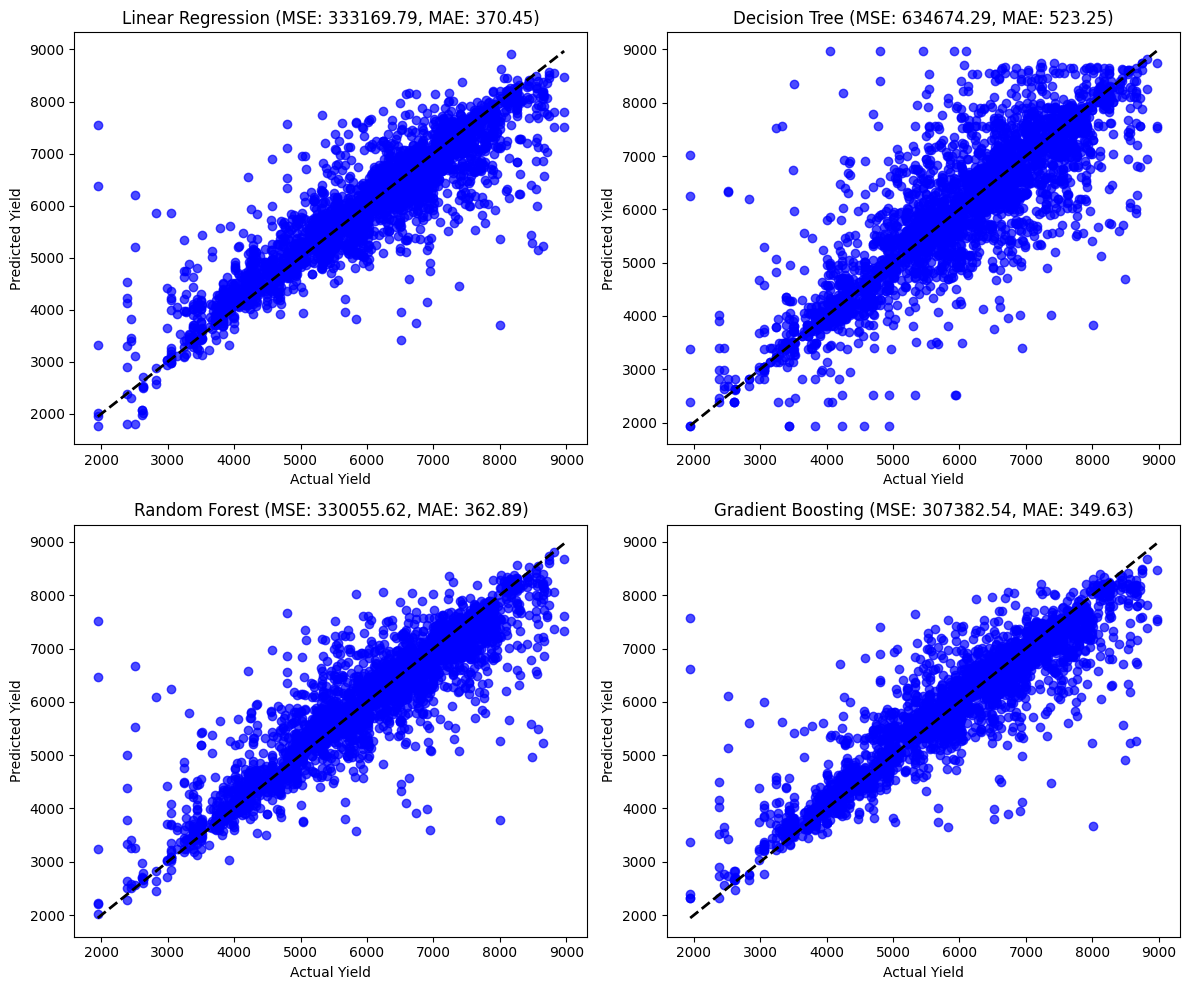

Results file created using Gradient Boosting model.


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Separate features and target variable from the training set
X = train_df.drop(columns=['id', 'yield'])  # Drop 'id' and target column 'yield'
y = train_df['yield']  # Target variable

# Prepare test data
X_test = test_df.drop(columns=['id'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train each model, calculate metrics, and plot Actual vs. Predicted Yield
plt.figure(figsize=(12, 10))
model_performance = []

for i, (name, model) in enumerate(models.items(), 1):
    # Train model
    model.fit(X_train, y_train)
    # Predict on validation set
    y_pred = model.predict(X_val)

    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    model_performance.append((name, mse, mae, r2))
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R^2: {r2:.2f}")

    # Plot Actual vs. Predicted Yield
    plt.subplot(2, 2, i)
    plt.scatter(y_val, y_pred, alpha=0.7, color='blue')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"{name} (MSE: {mse:.2f}, MAE: {mae:.2f})")

plt.tight_layout()
plt.show()

# Choose the best model based on MSE (or another metric)
best_model_name, _, _, _ = min(model_performance, key=lambda x: x[1])  # Use MSE as criterion
best_model = models[best_model_name]

# Train the best model on the full training data
best_model.fit(X, y)

# Make predictions on the test data
y_test_pred = best_model.predict(X_test)

# Prepare the results file
results = pd.DataFrame({'id': test_df['id'], 'yield': y_test_pred})
results.to_csv('results.csv', index=False)

print(f"Results file created using {best_model_name} model.")